<a href="https://colab.research.google.com/github/thxsxth/RLMimic/blob/master/Sepsis3_initial_work.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [103]:
cd 'drive/My Drive/sepsis3-cohort'

[Errno 2] No such file or directory: 'drive/My Drive/sepsis3-cohort'
/content/drive/My Drive/sepsis3-cohort


# This Notebook presents the interative (rough) work done when deifining cohorts, there was errors and included to show the mistakes that were done
The csv files were derived using GCP Big Query, and SQL and Amazon AWS Athena, Some cohort analysis codes were  from https://github.com/alistairewj/sepsis3-mimic/tree/master/query 

In [0]:
import pandas as pd
import numpy as np

In [0]:
df=pd.read_csv('sepsis3-cohort.csv')

In [0]:
df.head()

,icustay_id,hadm_id,excluded,intime,outtime,dbsource,suspected_infection_time_poe,suspected_infection_time_poe_days,specimen_poe,positiveculture_poe,antibiotic_time_poe,blood_culture_time,blood_culture_positive,age,gender,is_male,ethnicity,race_white,race_black,race_hispanic,race_other,Height,Weight,bmi,first_service,HOSPITAL_EXPIRE_FLAG,THIRTYDAY_EXPIRE_FLAG,icu_los,hosp_los,sepsis_angus,sepsis_martin,sepsis_explicit,septic_shock_explicit,severe_sepsis_explicit,sepsis_nqf,sepsis_cdc,sepsis_cdc_simple,vent,sofa,lods,sirs,qsofa,qsofa_sysbp_score,qsofa_gcs_score,qsofa_resprate_score
0,200001,152234,1,2181-11-25 19:06:12,2181-11-28 20:59:25,metavision,NaN,NaN,NaN,NaN,2181-11-23 00:00:00,2181-11-24 00:12:00,1,61.0,F,0,ASIAN - ASIAN INDIAN,0,0,0,1,170.180000,61.0,21.062640,MED,0,0,3.0786,16,0,0,0,0,0,0,0,0,0,6,7,3,2,1.0,NaN,1.0
1,200003,163557,1,2199-08-02 19:50:04,2199-08-08 17:09:18,carevue,NaN,NaN,NaN,NaN,2199-08-02 00:00:00,2199-08-02 21:02:00,1,48.0,M,1,WHITE,1,0,0,0,177.800000,77.0,24.357192,SURG,0,0,5.8884,20,1,1,0,0,0,1,0,0,0,4,4,4,2,1.0,0.0,1.0
2,200006,189514,1,2159-09-03 11:28:14,2159-09-04 19:08:10,carevue,NaN,NaN,NaN,NaN,NaN,2159-09-03 09:00:00,1,54.0,M,1,OTHER,0,0,0,1,168.002857,82.4,29.194018,MED,0,0,1.3194,2,0,0,0,0,0,0,0,0,0,1,2,2,2,1.0,0.0,1.0
3,200007,129310,1,2109-02-17 10:03:37,2109-02-18 17:03:12,carevue,NaN,NaN,NaN,NaN,NaN,NaN,0,44.0,M,1,WHITE,1,0,0,0,177.800000,126.0,39.857223,CMED,0,0,1.2914,3,0,0,0,0,0,0,0,0,0,1,2,2,2,1.0,0.0,1.0
4,200009,129607,1,2189-11-30 10:34:32,2189-12-02 14:17:37,carevue,NaN,NaN,NaN,NaN,2189-12-01 00:00:00,NaN,0,47.0,F,0,WHITE,1,0,0,0,161.290000,87.2,33.519814,CSURG,0,0,2.1549,6,0,0,0,0,0,0,0,0,0,3,4,4,2,1.0,0.0,1.0


In [0]:
df[df.excluded==0].shape

(12965, 45)

In [0]:
df['suspected_infection_time_poe'].notnull()

0        False
1        False
2        False
3        False
4        False
         ...  
61527    False
61528     True
61529    False
61530    False
61531    False
Name: suspected_infection_time_poe, Length: 61532, dtype: bool

In [0]:
np.sum(df['sofa']>2), np.sum(df['suspected_infection_time_poe'].notnull())

(36926, 9754)

In [0]:
np.sum(df[df['sofa']>2]['suspected_infection_time_poe'].notnull())

6525

In [0]:
df[df.sepsis_explicit==1].count()

icustay_id                           4734
hadm_id                              4734
excluded                             4734
intime                               4734
outtime                              4734
dbsource                             4734
suspected_infection_time_poe         1007
suspected_infection_time_poe_days    1007
specimen_poe                         1007
positiveculture_poe                  1007
antibiotic_time_poe                  4681
blood_culture_time                   4558
blood_culture_positive               4734
age                                  4734
gender                               4734
is_male                              4734
ethnicity                            4734
race_white                           4734
race_black                           4734
race_hispanic                        4734
race_other                           4734
Height                               3450
Weight                               4314
bmi                               

In [0]:
co=pd.read_csv('Sepsis3_with_exclusions.csv')

In [0]:

# print out the exclusions
print('Cohort - initial size: {} ICU stays'.format(co.shape[0]))
idxRem = np.zeros(co.shape[0])
for c in co.columns:
    if c.startswith('exclusion_'):
        print('  {:5g} ({:2.2f}%) - {}'.format(np.sum(co[c]),np.mean(co[c])*100.0, c))
        idxRem[co[c].values==1] = 1
        
print('Final cohort size: {} ICU stays ({:2.2f}%).'.format(co.shape[0] - np.sum(idxRem), (1-np.mean(idxRem))*100.0))

Cohort - initial size: 61532 ICU stays
    491 (0.80%) - exclusion_bad_data
   1087 (1.77%) - exclusion_late_suspicion
  15056 (24.47%) - exclusion_secondarystay
   8119 (13.19%) - exclusion_nonadult
   7343 (11.93%) - exclusion_csurg
  37912 (61.61%) - exclusion_carevue
   1988 (3.23%) - exclusion_early_suspicion
Final cohort size: 12965.0 ICU stays (21.07%).


In [0]:
# print out the exclusions *SEQUENTIALLY* - i.e. if already excluded, don't re-print
print('Cohort - initial size: {} ICU stays'.format(co.shape[0]))

COL_REM = ['exclusion_nonadult', 'exclusion_secondarystay','exclusion_carevue',
           'exclusion_csurg',
           'exclusion_early_suspicion', 'exclusion_late_suspicion', 'exclusion_bad_data']

idxRem = np.zeros(co.shape[0])
for c in COL_REM:
    N_REM = np.sum( (idxRem == 0) & (co[c].values==1) )
    print('  {:5g} ({:2.2f}%) - {}'.format(N_REM,N_REM*100.0/co.shape[0], c))
    idxRem[co[c].values==1] = 1
        
print('Final non-suspected cohort size: {:g} ICU stays ({:2.2f}%).'.format(co.shape[0] - np.sum(idxRem), (1-np.mean(idxRem))*100.0))
print('Of these patients...')
c='suspected_infection_time_poe'
N_REM = np.sum( (idxRem) & (co[c].notna()) )
print('  {:5g} ({:2.2f}%) - {}'.format(N_REM, N_REM*100.0/ (co.shape[0] - np.sum(idxRem)), c))
d='suspected_infection_time_poe_days'
N_REM = np.sum( (idxRem) & (co[d].notna()) )
print('  {:5g} ({:2.2f}%) - {}'.format(N_REM, N_REM*100.0/ (co.shape[0] - np.sum(idxRem)), d))


print()
# define idxRem to exclude non-metavision admissions initially
print('=============================')
print('====== METAVISION ONLY ======')
print(' Patients admitted 2008-2012 ')
print('=============================')
print()

idxRem = co['dbsource']!='metavision'
N = np.sum(~idxRem)
N_IGNORE = np.sum(idxRem)

# print out the exclusions *SEQUENTIALLY* - i.e. if already excluded, don't re-print
print('Cohort - initial size: {} ICU stays'.format(N))

for c in COL_REM:
    N_REM = np.sum( (idxRem == 0) & (co[c].values==1) )
    print('  {:5g} ({:2.2f}%) - {}'.format(N_REM,N_REM*100.0/N, c))
    idxRem[co[c].values==1] = True
        
print('Final non-suspected cohort size: {}/{} ICU stays ({:2.2f}%).'.format(
        np.sum(~idxRem), N, np.sum(~idxRem)*100.0/N))
print('')

print('Of these patients...')
for c in ['suspected_infection_time_poe','suspected_infection_time_poe_days']:
  N_REM = np.sum( (~idxRem) & (co[c].notna()) )
  print('  {:5g} ({:2.2f}%) - {}'.format(N_REM, N_REM*100.0/ np.sum(~idxRem), c))

Cohort - initial size: 61532 ICU stays
   8119 (13.19%) - exclusion_nonadult
  14826 (24.09%) - exclusion_secondarystay
  22508 (36.58%) - exclusion_carevue
   2298 (3.73%) - exclusion_csurg
    485 (0.79%) - exclusion_early_suspicion
    310 (0.50%) - exclusion_late_suspicion
     21 (0.03%) - exclusion_bad_data
Final non-suspected cohort size: 12965 ICU stays (21.07%).
Of these patients...
   7509 (57.92%) - suspected_infection_time_poe
   7509 (57.92%) - suspected_infection_time_poe_days

====== METAVISION ONLY ======
 Patients admitted 2008-2012 

Cohort - initial size: 23620 ICU stays
      5 (0.02%) - exclusion_nonadult
   7536 (31.91%) - exclusion_secondarystay
      0 (0.00%) - exclusion_carevue
   2298 (9.73%) - exclusion_csurg
    485 (2.05%) - exclusion_early_suspicion
    310 (1.31%) - exclusion_late_suspicion
     21 (0.09%) - exclusion_bad_data
Final non-suspected cohort size: 12965/23620 ICU stays (54.89%).

Of these patients...
   2245 (17.32%) - suspected_infection_tim

In [0]:
co.columns

Index(['icustay_id', 'hadm_id', 'excluded', 'intime', 'outtime', 'dbsource',
       'suspected_infection_time_poe', 'suspected_infection_time_poe_days',
       'specimen_poe', 'positiveculture_poe', 'antibiotic_time_poe',
       'blood_culture_time', 'blood_culture_positive', 'age', 'gender',
       'is_male', 'ethnicity', 'exclusion_bad_data',
       'exclusion_late_suspicion', 'exclusion_secondarystay',
       'exclusion_nonadult', 'exclusion_csurg', 'exclusion_carevue',
       'exclusion_early_suspicion', 'race_white', 'race_black',
       'race_hispanic', 'race_other', 'Height', 'Weight', 'bmi',
       'first_service', 'HOSPITAL_EXPIRE_FLAG', 'THIRTYDAY_EXPIRE_FLAG',
       'icu_los', 'hosp_los', 'sepsis_angus', 'sepsis_martin',
       'sepsis_explicit', 'septic_shock_explicit', 'severe_sepsis_explicit',
       'sepsis_nqf', 'sepsis_cdc', 'sepsis_cdc_simple', 'vent', 'sofa', 'lods',
       'sirs', 'qsofa', 'qsofa_sysbp_score', 'qsofa_gcs_score',
       'qsofa_resprate_score'],
    

In [0]:
# colours for prettier plots
import matplotlib
import matplotlib.pyplot as plt
import colorsys
def gg_color_hue(n):
    hues = np.linspace(15, 375, n)
    hsv_tuples = [(x*1.0/360.0, 0.5, 0.8) for x in hues]
    rgb_tuples = map(lambda x: colorsys.hsv_to_rgb(*x), hsv_tuples)
    return rgb_tuples

marker = ['v','o','d','^','s','o','+']
ls = ['-','-','-','-','-','s','--','--']

# plot settings
%matplotlib inline
plt.style.use('ggplot')
font = {'size'   : 20}
matplotlib.rc('font', **font)

#### Let's compare Sepsis 3 cohorts of Big Query and Athena (These should be the same)

In [0]:
df_athena=pd.read_csv('sepsis3-cohort_athena.csv' )

In [104]:
df_athena.head()

,Unnamed: 0,hadm_id,icustay_id,intime,outtime,age,gender,ethnicity,first_service,dbsource,suspected_of_infection_poe,suspected_infection_time_poe,suspected_infection_time_poe_days,specimen_poe,positiveculture_poe,antibiotic_time_poe,exclusion_secondarystay,exclusion_nonadult,exclusion_csurg,exclusion_carevue,exclusion_early_suspicion,exclusion_late_suspicion,exclusion_bad_data,excluded
0,0,152234,200001,2181-11-25 19:06:12,2181-11-28 20:59:25,-61.0,F,ASIAN - ASIAN INDIAN,MED,metavision,1,2181-11-18 00:00:00,7.795972,BLOOD CULTURE,0.0,2181-11-18 00:00:00,1,1,0,0,1,0,0,1
1,1,163557,200003,2199-08-02 19:50:04,2199-08-08 17:09:18,-48.0,M,WHITE,SURG,carevue,1,2199-08-02 00:00:00,0.826435,BLOOD CULTURE,1.0,2199-08-02 00:00:00,0,1,0,1,0,0,0,1
2,2,189514,200006,2159-09-03 11:28:14,2159-09-04 19:08:10,-54.0,M,OTHER,MED,carevue,0,NaN,NaN,NaN,NaN,NaN,1,1,0,1,0,0,0,1
3,3,129310,200007,2109-02-17 10:03:37,2109-02-18 17:03:12,-43.0,M,WHITE,CMED,carevue,0,NaN,NaN,NaN,NaN,NaN,0,1,0,1,0,0,0,1
4,4,129607,200009,2189-11-30 10:34:32,2189-12-02 14:17:37,-47.0,F,WHITE,CSURG,carevue,1,2189-11-30 00:00:00,0.440648,NaN,NaN,2189-11-30 00:00:00,0,1,1,1,0,0,0,1


In [0]:
df_athena.count()

Unnamed: 0                           61532
hadm_id                              61532
icustay_id                           61532
intime                               61532
outtime                              61522
age                                  61532
gender                               61532
ethnicity                            61532
first_service                        61512
dbsource                             61532
suspected_of_infection_poe           61532
suspected_infection_time_poe         41068
suspected_infection_time_poe_days    41068
specimen_poe                         31290
positiveculture_poe                  31290
antibiotic_time_poe                  41068
exclusion_secondarystay              61532
exclusion_nonadult                   61532
exclusion_csurg                      61532
exclusion_carevue                    61532
exclusion_early_suspicion            61532
exclusion_late_suspicion             61532
exclusion_bad_data                   61532
excluded   

In [0]:
df_bq=pd.read_csv('Sepsis3_bq.csv')

In [0]:
df_bq.head()

,hadm_id,icustay_id,intime,outtime,age,gender,ethnicity,first_service,dbsource,suspected_of_infection_poe,suspected_infection_time_poe,suspected_infection_time_poe_days,specimen_poe,positiveculture_poe,antibiotic_time_poe,exclusion_secondarystay,exclusion_nonadult,exclusion_csurg,exclusion_carevue,exclusion_early_suspicion,exclusion_late_suspicion,exclusion_bad_data,excluded
0,152234,200001,2181-11-25 19:06:12,2181-11-28 20:59:25,61.0,F,ASIAN - ASIAN INDIAN,MED,metavision,0,NaN,NaN,NaN,NaN,2181-11-23 00:00:00,1,0,0,0,0,0,0,1
1,163557,200003,2199-08-02 19:50:04,2199-08-08 17:09:18,48.0,M,WHITE,SURG,carevue,0,NaN,NaN,NaN,NaN,2199-08-02 00:00:00,0,0,0,1,0,0,0,1
2,189514,200006,2159-09-03 11:28:14,2159-09-04 19:08:10,54.0,M,OTHER,MED,carevue,0,NaN,NaN,NaN,NaN,NaN,1,0,0,1,0,0,0,1
3,129310,200007,2109-02-17 10:03:37,2109-02-18 17:03:12,44.0,M,WHITE,CMED,carevue,0,NaN,NaN,NaN,NaN,NaN,0,0,0,1,0,0,0,1
4,129607,200009,2189-11-30 10:34:32,2189-12-02 14:17:37,47.0,F,WHITE,CSURG,carevue,0,NaN,NaN,NaN,NaN,2189-12-01 00:00:00,0,0,1,1,0,0,0,1


In [0]:
df_bq.count()

hadm_id                              61532
icustay_id                           61532
intime                               61532
outtime                              61522
age                                  61532
gender                               61532
ethnicity                            61532
first_service                        61512
dbsource                             61532
suspected_of_infection_poe           61532
suspected_infection_time_poe          9754
suspected_infection_time_poe_days     9754
specimen_poe                          9754
positiveculture_poe                   9754
antibiotic_time_poe                  40972
exclusion_secondarystay              61532
exclusion_nonadult                   61532
exclusion_csurg                      61532
exclusion_carevue                    61532
exclusion_early_suspicion            61532
exclusion_late_suspicion             61532
exclusion_bad_data                   61532
excluded                             61532
dtype: int6

In [0]:
df_bq.describe()

,hadm_id,icustay_id,age,suspected_of_infection_poe,suspected_infection_time_poe_days,positiveculture_poe,exclusion_secondarystay,exclusion_nonadult,exclusion_csurg,exclusion_carevue,exclusion_early_suspicion,exclusion_late_suspicion,exclusion_bad_data,excluded
count,61532.000000,61532.000000,61532.000000,61532.000000,9754.000000,9754.00000,61532.000000,61532.000000,61532.000000,61532.000000,61532.000000,61532.000000,61532.000000,61532.000000
mean,149954.470649,249962.710248,55.635107,0.158519,0.542034,0.18413,0.244686,0.131948,0.119336,0.616135,0.032308,0.017666,0.007980,0.789297
std,28898.895904,28890.574867,27.006630,0.365230,4.029844,0.38761,0.429904,0.338437,0.324186,0.486330,0.176819,0.131734,0.088972,0.407811
min,100001.000000,200001.000000,0.000000,0.000000,-48.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,124933.750000,224935.500000,44.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,149911.500000,249940.000000,62.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
75%,174997.250000,274972.500000,76.000000,0.000000,1.000000,0.00000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
max,199999.000000,299999.000000,91.400000,1.000000,70.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [0]:
df_athena.describe()

,Unnamed: 0,hadm_id,icustay_id,age,suspected_of_infection_poe,suspected_infection_time_poe_days,positiveculture_poe,exclusion_secondarystay,exclusion_nonadult,exclusion_csurg,exclusion_carevue,exclusion_early_suspicion,exclusion_late_suspicion,exclusion_bad_data,excluded
count,61532.000000,61532.000000,61532.000000,61532.000000,61532.000000,41068.000000,31290.000000,61532.000000,61532.0,61532.000000,61532.000000,61532.000000,61532.000000,61532.000000,61532.0
mean,30765.500000,149954.470649,249962.710248,-64.466912,0.667425,2.086798,0.170853,0.244686,1.0,0.119336,0.616135,0.155285,0.045619,0.007980,1.0
std,17762.902719,28898.895904,28890.574867,56.913506,0.471140,27.211112,0.376387,0.429904,0.0,0.324186,0.486330,0.362179,0.208658,0.088972,0.0
min,0.000000,100001.000000,200001.000000,-311.000000,0.000000,-163.045775,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
25%,15382.750000,124933.750000,224935.500000,-76.000000,0.000000,0.072902,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
50%,30765.500000,149911.500000,249940.000000,-62.000000,1.000000,0.508727,0.000000,0.000000,1.0,0.000000,1.000000,0.000000,0.000000,0.000000,1.0
75%,46148.250000,174997.250000,274972.500000,-44.000000,1.000000,0.911794,0.000000,0.000000,1.0,0.000000,1.000000,0.000000,0.000000,0.000000,1.0
max,61531.000000,199999.000000,299999.000000,0.000000,1.000000,3652.463032,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.0


#### Let's try to change suspected_of_infection_poe from Athena to BQ can see if it changes things

In [0]:
co=pd.read_csv('Sepsis3_with_exclusions.csv')

In [0]:
co.columns

Index(['icustay_id', 'hadm_id', 'excluded', 'intime', 'outtime', 'dbsource',
       'suspected_infection_time_poe', 'suspected_infection_time_poe_days',
       'specimen_poe', 'positiveculture_poe', 'antibiotic_time_poe',
       'blood_culture_time', 'blood_culture_positive', 'age', 'gender',
       'is_male', 'ethnicity', 'exclusion_bad_data',
       'exclusion_late_suspicion', 'exclusion_secondarystay',
       'exclusion_nonadult', 'exclusion_csurg', 'exclusion_carevue',
       'exclusion_early_suspicion', 'race_white', 'race_black',
       'race_hispanic', 'race_other', 'Height', 'Weight', 'bmi',
       'first_service', 'HOSPITAL_EXPIRE_FLAG', 'THIRTYDAY_EXPIRE_FLAG',
       'icu_los', 'hosp_los', 'sepsis_angus', 'sepsis_martin',
       'sepsis_explicit', 'septic_shock_explicit', 'severe_sepsis_explicit',
       'sepsis_nqf', 'sepsis_cdc', 'sepsis_cdc_simple', 'vent', 'sofa', 'lods',
       'sirs', 'qsofa', 'qsofa_sysbp_score', 'qsofa_gcs_score',
       'qsofa_resprate_score'],
    

In [0]:
for column in ['suspected_infection_time_poe','suspected_infection_time_poe_days']:
  co[column]=df_athena[column]

In [0]:
# print out the exclusions *SEQUENTIALLY* - i.e. if already excluded, don't re-print
print('Cohort - initial size: {} ICU stays'.format(co.shape[0]))

COL_REM = ['exclusion_nonadult', 'exclusion_secondarystay','exclusion_carevue',
           'exclusion_csurg',
           'exclusion_early_suspicion', 'exclusion_late_suspicion', 'exclusion_bad_data']

idxRem = np.zeros(co.shape[0])
for c in COL_REM:
    N_REM = np.sum( (idxRem == 0) & (co[c].values==1) )
    print('  {:5g} ({:2.2f}%) - {}'.format(N_REM,N_REM*100.0/co.shape[0], c))
    idxRem[co[c].values==1] = 1
        
print('Final non-suspected cohort size: {:g} ICU stays ({:2.2f}%).'.format(co.shape[0] - np.sum(idxRem), (1-np.mean(idxRem))*100.0))
print('Of these patients...')
c='suspected_infection_time_poe'
N_REM = np.sum( (idxRem) & (co[c].notna()) )
print('  {:5g} ({:2.2f}%) - {}'.format(N_REM, N_REM*100.0/ (co.shape[0] - np.sum(idxRem)), c))
d='suspected_infection_time_poe_days'
N_REM = np.sum( (idxRem) & (co[d].notna()) )
print('  {:5g} ({:2.2f}%) - {}'.format(N_REM, N_REM*100.0/ (co.shape[0] - np.sum(idxRem)), d))


print()
# define idxRem to exclude non-metavision admissions initially
print('=============================')
print('====== METAVISION ONLY ======')
print(' Patients admitted 2008-2012 ')
print('=============================')
print()

idxRem = co['dbsource']!='metavision'
N = np.sum(~idxRem)
N_IGNORE = np.sum(idxRem)

# print out the exclusions *SEQUENTIALLY* - i.e. if already excluded, don't re-print
print('Cohort - initial size: {} ICU stays'.format(N))

for c in COL_REM:
    N_REM = np.sum( (idxRem == 0) & (co[c].values==1) )
    print('  {:5g} ({:2.2f}%) - {}'.format(N_REM,N_REM*100.0/N, c))
    idxRem[co[c].values==1] = True
        
print('Final non-suspected cohort size: {}/{} ICU stays ({:2.2f}%).'.format(
        np.sum(~idxRem), N, np.sum(~idxRem)*100.0/N))
print('')

print('Of these patients...')
for c in ['suspected_infection_time_poe','suspected_infection_time_poe_days']:
  N_REM = np.sum( (~idxRem) & (co[c].notna()) )
  print('  {:5g} ({:2.2f}%) - {}'.format(N_REM, N_REM*100.0/ np.sum(~idxRem), c))

Cohort - initial size: 61532 ICU stays
   8119 (13.19%) - exclusion_nonadult
  14826 (24.09%) - exclusion_secondarystay
  22508 (36.58%) - exclusion_carevue
   2298 (3.73%) - exclusion_csurg
    485 (0.79%) - exclusion_early_suspicion
    310 (0.50%) - exclusion_late_suspicion
     21 (0.03%) - exclusion_bad_data
Final non-suspected cohort size: 12965 ICU stays (21.07%).
Of these patients...
  32357 (249.57%) - suspected_infection_time_poe
  32357 (249.57%) - suspected_infection_time_poe_days

====== METAVISION ONLY ======
 Patients admitted 2008-2012 

Cohort - initial size: 23620 ICU stays
      5 (0.02%) - exclusion_nonadult
   7536 (31.91%) - exclusion_secondarystay
      0 (0.00%) - exclusion_carevue
   2298 (9.73%) - exclusion_csurg
    485 (2.05%) - exclusion_early_suspicion
    310 (1.31%) - exclusion_late_suspicion
     21 (0.09%) - exclusion_bad_data
Final non-suspected cohort size: 12965/23620 ICU stays (54.89%).

Of these patients...
   8711 (67.19%) - suspected_infection_t

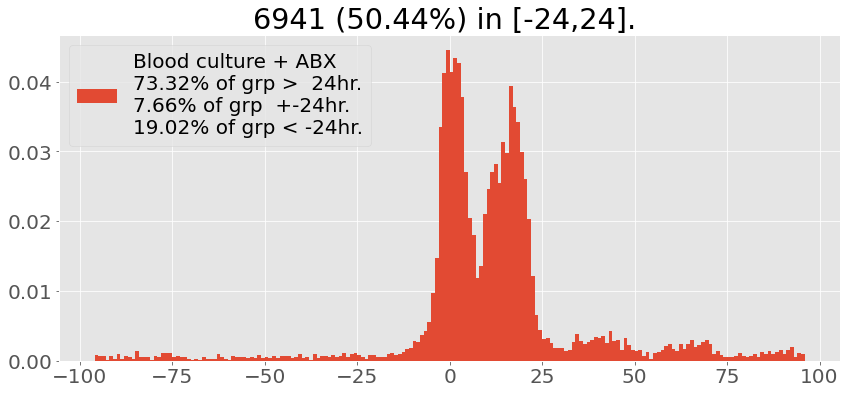

In [0]:
# generate exclusions *except* early/late suspicion
COL_REM = ['exclusion_nonadult', 'exclusion_secondarystay',
           'exclusion_csurg','exclusion_carevue',
           #'exclusion_early_suspicion', 'exclusion_late_suspicion',
           'exclusion_bad_data']
idxRem = np.zeros(co.shape[0])

for c in COL_REM:
    N_REM = np.sum( (idxRem == 0) & (co[c].values==1) )
    idxRem[co[c].values==1] = 1
    
idxRem = idxRem.astype(bool)

# distribution of time of infection
N_HR = 96
xi = np.linspace(-N_HR, N_HR, N_HR*2+1)
col = gg_color_hue(5)

pretty_dict = {'suspected_infection_time_poe_days': 'Blood culture + ABX'}
c = 'suspected_infection_time_poe_days'

idxKeep = ~co[c].isnull()
tmp = co.loc[~idxRem & idxKeep, c].values* 24.0
N_firstday = sum( (tmp>-24) & (tmp<24) )
# N_firstday = sum( (tmp>-1) & (tmp<1) )

lbl_str = pretty_dict[c]
lbl_str += '\n' + '{:2.2f}% of grp >  24hr.'.format(sum(tmp>1)*100.0 / np.sum(~idxRem & idxKeep))
lbl_str += '\n' + '{:2.2f}% of grp  +-24hr.'.format(sum((tmp>=-1) & (tmp<=1))*100.0 / np.sum(~idxRem & idxKeep))
lbl_str += '\n' + '{:2.2f}% of grp < -24hr.'.format(sum(tmp<-1)*100.0 / np.sum(~idxRem & idxKeep))

plt.figure(figsize=[14,6])
plt.hist( tmp, bins=xi, label=lbl_str , density=True)
plt.title('{} ({:2.2f}%) in [-24,24]. '.format(
        N_firstday, N_firstday*100.0 / np.sum(~idxRem)))
plt.legend(loc='upper left')
    
plt.show()

### Let's try if we can get results from Sepsis 3 paper

In [0]:
from collections import OrderedDict
df=co[co['excluded']==0]
df['composite_outcome'] = ( (df['HOSPITAL_EXPIRE_FLAG']==1) | (df['icu_los']>=3) ).astype(int)

labels = OrderedDict([['suspicion_poe', 'BC + ABX (Prescribed)']])

# add some other useful variables
df['blood culture'] = (~df['blood_culture_time'].isnull())
df['suspicion_poe'] = (~df['suspected_infection_time_poe_days'].isnull())

df['abx_poe'] = (~df['antibiotic_time_poe'].isnull())

df['sepsis-3'] = ((df['suspicion_poe']==1) & (df['sofa']>=2)).astype(int)
df['sofa>=2'] = (df['sofa']>=2).astype(int)



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

In [0]:

for c in ['intime','outtime',
          'suspected_infection_time_mv','suspected_infection_time',
          'suspected_infection_time_poe', 'blood_culture_time']:
    if c in df.columns:
        if df[c].dtype == 'object':
            df[c] = pd.to_datetime(df[c])

# list of the sepsis definitions
sepsis_list = ['sepsis_angus','sepsis_martin', 'sepsis_explicit',
               'sepsis_cdc','sepsis_nqf',
               'sepsis-3']

In [0]:
print('{:5g} patients.'.format(df.shape[0]))

print('{:5g} ({:2.0f}%) suspected of infection.'.format(
        df['suspicion_poe'].sum(), df['suspicion_poe'].sum()*100.0/df.shape[0]))

print('{:5g} ({:2.2f}%) have SOFA >= 2.'.format(
    df['sofa>=2'].sum(),100.0*df['sofa>=2'].mean()))

print('{:5g} ({:2.2f}%) have Sepsis-3 criteria (intersection of above two).'.format(
    df['sepsis-3'].sum(),100.0*df['sepsis-3'].mean()))

print('{:5g} ({:2.2f}%) have suspicion and SOFA < 2.'.format(
        ((df['sofa>=2']==0) & (df['suspicion_poe']==1)).sum(),
        ((df['sofa>=2']==0) & (df['suspicion_poe']==1)).sum()*100.0/df.shape[0]))

for c in sepsis_list:
    print('{:5g} ({:3.2f}%) - {}'.format(
        df[c].sum(), df[c].sum()*100.0/df.shape[0], c))

print('{:5g} ({:2.2f}%) have Sepsis-3 criteria but not Angus.'.format(
        ((df['sepsis_angus']==0) & (df['sepsis-3']==1)).sum(),
        ((df['sepsis_angus']==0) & (df['sepsis-3']==1)).sum()*100.0/df.shape[0]))


np.random.seed(21381)
# calpha = su.cronbach_alpha_table(df, sepsis_list)

# # remove "sepsis_" prefix from columns/indices
# calpha.columns = [x.replace('sepsis_','') for x in calpha.columns]
# calpha.index = [x.replace('sepsis_','') for x in calpha.index]

# print('\n === Cronbach Alpha ===')
# display(HTML(calpha.fillna('').to_html()))

12965 patients.
 8711 (67%) suspected of infection.
 9801 (75.60%) have SOFA >= 2.
 6954 (53.64%) have Sepsis-3 criteria (intersection of above two).
 1757 (13.55%) have suspicion and SOFA < 2.
 4049 (31.23%) - sepsis_angus
 2010 (15.50%) - sepsis_martin
 1202 (9.27%) - sepsis_explicit
 1404 (10.83%) - sepsis_cdc
 1474 (11.37%) - sepsis_nqf
 6954 (53.64%) - sepsis-3
 3732 (28.79%) have Sepsis-3 criteria but not Angus.


#### Let's do without exclusions and see

In [0]:
from collections import OrderedDict
df=co
df['composite_outcome'] = ( (df['HOSPITAL_EXPIRE_FLAG']==1) | (df['icu_los']>=3) ).astype(int)

labels = OrderedDict([['suspicion_poe', 'BC + ABX (Prescribed)']])

# add some other useful variables
df['blood culture'] = (~df['blood_culture_time'].isnull())
df['suspicion_poe'] = (~df['suspected_infection_time_poe_days'].isnull())

df['abx_poe'] = (~df['antibiotic_time_poe'].isnull())

df['sepsis-3'] = ((df['suspicion_poe']==1) & (df['sofa']>=2)).astype(int)
df['sofa>=2'] = (df['sofa']>=2).astype(int)


In [0]:
for c in ['intime','outtime',
          'suspected_infection_time_mv','suspected_infection_time',
          'suspected_infection_time_poe', 'blood_culture_time']:
    if c in df.columns:
        if df[c].dtype == 'object':
            df[c] = pd.to_datetime(df[c])

# list of the sepsis definitions
sepsis_list = ['sepsis_angus','sepsis_martin', 'sepsis_explicit',
               'sepsis_cdc','sepsis_nqf',
               'sepsis-3']

In [0]:
print('{:5g} patients.'.format(df.shape[0]))

print('{:5g} ({:2.0f}%) suspected of infection.'.format(
        df['suspicion_poe'].sum(), df['suspicion_poe'].sum()*100.0/df.shape[0]))

print('{:5g} ({:2.2f}%) have SOFA >= 2.'.format(
    df['sofa>=2'].sum(),100.0*df['sofa>=2'].mean()))

print('{:5g} ({:2.2f}%) have Sepsis-3 criteria (intersection of above two).'.format(
    df['sepsis-3'].sum(),100.0*df['sepsis-3'].mean()))

print('{:5g} ({:2.2f}%) have suspicion and SOFA < 2.'.format(
        ((df['sofa>=2']==0) & (df['suspicion_poe']==1)).sum(),
        ((df['sofa>=2']==0) & (df['suspicion_poe']==1)).sum()*100.0/df.shape[0]))

for c in sepsis_list:
    print('{:5g} ({:3.2f}%) - {}'.format(
        df[c].sum(), df[c].sum()*100.0/df.shape[0], c))

print('{:5g} ({:2.2f}%) have Sepsis-3 criteria but not Angus.'.format(
        ((df['sepsis_angus']==0) & (df['sepsis-3']==1)).sum(),
        ((df['sepsis_angus']==0) & (df['sepsis-3']==1)).sum()*100.0/df.shape[0]))

61532 patients.
41068 (67%) suspected of infection.
45668 (74.22%) have SOFA >= 2.
32913 (53.49%) have Sepsis-3 criteria (intersection of above two).
 8155 (13.25%) have suspicion and SOFA < 2.
17420 (28.31%) - sepsis_angus
 9028 (14.67%) - sepsis_martin
 4734 (7.69%) - sepsis_explicit
 4151 (6.75%) - sepsis_cdc
 6329 (10.29%) - sepsis_nqf
32913 (53.49%) - sepsis-3
19496 (31.68%) have Sepsis-3 criteria but not Angus.


In [0]:
sepsis3_final_cohort=df[df['sepsis-3']==1]

In [0]:
icustays_1=sepsis3_final_cohort['icustay_id'].values

### Let's see if AI clinican's cohort is included here

In [0]:
with open('patientIDs_MIMIC3.csv') as file:
   icustays=file.readlines()

In [0]:
icustays=[200000+int(x[:-1]) for x in icustays]
len(icustays)

17083

In [0]:
icustays[:3], icustays_1[:3]

([200003, 200014, 200030], array([200001, 200003, 200009]))

### As we can see from below our cohort has 13214 of patients who were included in AI clinician so we can even focus on these

In [0]:
len(set(icustays)-set(icustays_1))

3869

In [0]:
17083-3869

13214

### The times do NOT make sense, they do make sense for Athena Though


In [106]:
sepsis3_final_cohort[['intime','outtime','suspected_infection_time_poe','suspected_infection_time_poe_days','HOSPITAL_EXPIRE_FLAG']]

,intime,outtime,suspected_infection_time_poe,suspected_infection_time_poe_days,HOSPITAL_EXPIRE_FLAG
0,2181-11-25 19:06:12,2181-11-28 20:59:25,2181-11-18,7.795972,0
1,2199-08-02 19:50:04,2199-08-08 17:09:18,2199-08-02,0.826435,0
4,2189-11-30 10:34:32,2189-12-02 14:17:37,2189-11-30,0.440648,0
6,2188-08-06 01:39:24,2188-08-07 16:50:53,2188-08-05,1.069028,0
8,2105-02-16 23:16:48,2105-02-18 16:53:29,2105-02-17,-0.030000,0
...,...,...,...,...,...
61525,2190-02-02 08:14:45,2190-02-23 21:09:36,2187-02-09,0.439699,0
61526,2105-11-21 21:14:34,2105-12-12 16:46:10,2152-02-28,7.650220,0
61528,2114-12-09 11:56:00,2114-12-15 20:29:14,2200-11-11,0.844433,0
61529,2116-03-04 17:44:39,2116-03-06 18:03:55,2184-05-13,1.465995,0


In [112]:
df_athena[df['suspected_infection_time_poe'].notnull()][['intime','outtime','suspected_infection_time_poe','suspected_infection_time_poe_days']]

,intime,outtime,suspected_infection_time_poe,suspected_infection_time_poe_days
0,2181-11-25 19:06:12,2181-11-28 20:59:25,2181-11-18 00:00:00,7.795972
1,2199-08-02 19:50:04,2199-08-08 17:09:18,2199-08-02 00:00:00,0.826435
4,2189-11-30 10:34:32,2189-12-02 14:17:37,2189-11-30 00:00:00,0.440648
6,2188-08-06 01:39:24,2188-08-07 16:50:53,2188-08-05 00:00:00,1.069028
7,2153-12-23 05:12:55,2153-12-23 15:55:54,2153-12-23 00:00:00,0.217303
...,...,...,...,...
61527,2111-05-06 12:43:53,2111-05-10 15:14:42,2111-05-06 00:00:00,0.530475
61528,2200-11-11 20:15:59,2200-11-14 11:41:50,2200-11-11 00:00:00,0.844433
61529,2184-05-14 11:11:02,2184-05-16 17:23:37,2184-05-13 00:00:00,1.465995
61530,2124-11-08 23:21:29,2124-11-20 00:03:48,2124-11-09 00:00:00,-0.026748
